In [113]:
# Imports
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from transformers import ViTModel, ViTImageProcessor
from peft import LoraConfig, get_peft_model
from dataset import FingerprintDataset
import time
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

In [114]:
# Transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load datasets
train_dataset = FingerprintDataset(json_file='net_pairs/train_pairs.json', transform=transform)
test_dataset = FingerprintDataset(json_file='net_pairs/test_pairs.json', transform=transform)

# Data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [115]:
# Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load a pre-trained ViT model and feature extractor
model_name = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(model_name)
base_model = ViTModel.from_pretrained(model_name)

# Apply LoRA using the PEFT library
config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="none",
    modules_to_save=["classifier"],
)
lora_model = get_peft_model(base_model, config)
lora_model.print_trainable_parameters()

trainable params: 589,824 || all params: 86,979,072 || trainable%: 0.6781217440443604


In [116]:
# Define the model class for embeddings
class ViTClassifier(nn.Module):
    def __init__(self, base_model):
        super(ViTClassifier, self).__init__()
        self.base_model = base_model
        self.base_model.classifier = nn.Identity()  # Remove the classifier layer to get embeddings
        self.fc = nn.Linear(base_model.config.hidden_size, 2)  # Add a classification head

    def forward(self, x):
        outputs = self.base_model(x).last_hidden_state[:, 0, :]
        logits = self.fc(outputs)
        return logits

# Instantiate the model
model = ViTClassifier(lora_model).to(device)

In [117]:
# Define the contrastive loss function
# class ContrastiveLoss(nn.Module):
#     def __init__(self, margin=1.0, pos_weight=1.0, neg_weight=10.0):
#         super(ContrastiveLoss, self).__init__()
#         self.margin = margin
#         self.pos_weight = pos_weight
#         self.neg_weight = neg_weight
# 
#     def forward(self, output1, output2, label):
#         euclidean_distance = nn.functional.pairwise_distance(output1, output2)
#         loss_contrastive = torch.mean((1 - label) * self.pos_weight * torch.pow(euclidean_distance, 2) +
#                                       (label) * self.neg_weight * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
#         return loss_contrastive
# 
# # Calculate weights
# num_pos = sum([1 for (images, label) in train_dataset if label == 1])
# num_neg = len(train_dataset) - num_pos
# pos_weight = len(train_dataset) / (2 * num_pos)
# neg_weight = len(train_dataset) / (2 * num_neg)
# 
# print(f"Number of positive samples: {num_pos}")
# print(f"Number of negative samples: {num_neg}")
# print(f"Positive weight: {pos_weight}")
# print(f"Negative weight: {neg_weight}")
# 
# criterion = ContrastiveLoss(pos_weight=pos_weight, neg_weight=neg_weight * 10)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=7, gamma=0.1)
# 
# torch.cuda.empty_cache()

# Define the cross-entropy loss function
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

torch.cuda.empty_cache()

Data transfer time: 0.0704 seconds
combined_logits shape: torch.Size([64, 2]), dtype: torch.float32
labels shape: torch.Size([64]), dtype: torch.int64
Forward pass time: 8.4110 seconds
Backward pass time: 0.0297 seconds
Batch 1/100, Batch Time: 14.35 seconds
Data transfer time: 0.0743 seconds
combined_logits shape: torch.Size([64, 2]), dtype: torch.float32
labels shape: torch.Size([64]), dtype: torch.int64
Forward pass time: 0.0231 seconds
Backward pass time: 0.0199 seconds
Batch 2/100, Batch Time: 11.87 seconds
Data transfer time: 0.0690 seconds
combined_logits shape: torch.Size([64, 2]), dtype: torch.float32
labels shape: torch.Size([64]), dtype: torch.int64
Forward pass time: 0.0230 seconds
Backward pass time: 0.0202 seconds
Batch 3/100, Batch Time: 14.40 seconds
Data transfer time: 0.0810 seconds
combined_logits shape: torch.Size([64, 2]), dtype: torch.float32
labels shape: torch.Size([64]), dtype: torch.int64
Forward pass time: 0.0292 seconds
Backward pass time: 0.0250 seconds
Bat

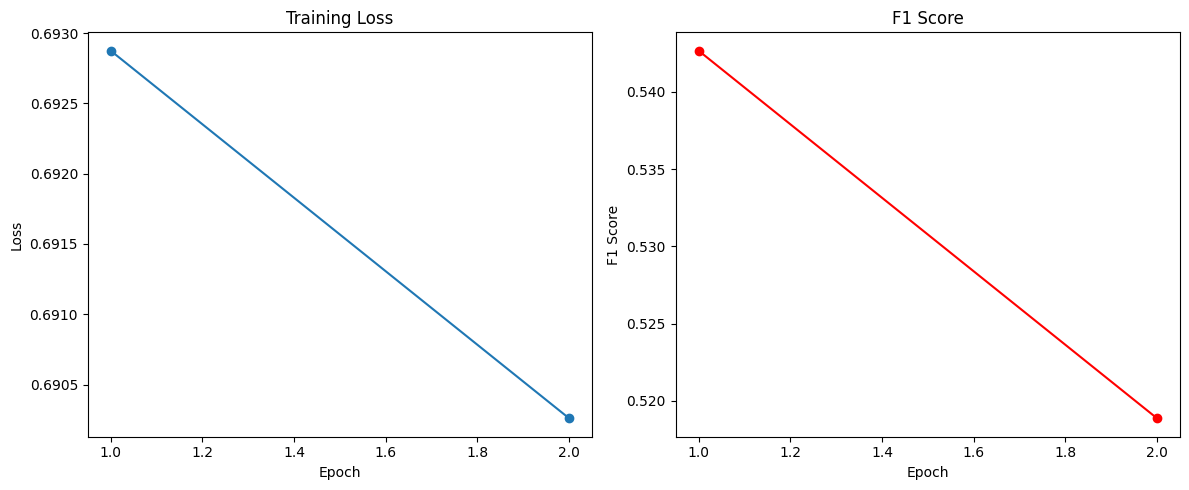

Mean F1 Score: 0.5308
True Positives (TP): 385
True Negatives (TN): 501
False Positives (FP): 295
False Negatives (FN): 419


In [118]:
# Initialize TensorBoard
# writer = SummaryWriter('runs/LoRA')

# Training the model
num_epochs = 2
f1_scores = []
losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    start_epoch_time = time.time()
    for i, data in enumerate(train_loader, 0):
        batch_start_time = time.time()
        (left_images, right_images), labels = data

        transfer_start_time = time.time()
        left_images, right_images, labels = left_images.to(device), right_images.to(device), labels.to(device)
        transfer_end_time = time.time()
        print(f"Data transfer time: {transfer_end_time - transfer_start_time:.4f} seconds")

        optimizer.zero_grad()
        
        forward_start_time = time.time()
        left_logits = model(left_images)
        right_logits = model(right_images)
        
        # Combine logits for classification
        combined_logits = (left_logits + right_logits) / 2
        
        # Ensure labels are long tensor
        labels = labels.long()
        
        # Print shapes and types
        print(f"combined_logits shape: {combined_logits.shape}, dtype: {combined_logits.dtype}")
        print(f"labels shape: {labels.shape}, dtype: {labels.dtype}")

        loss = criterion(combined_logits, labels)
        forward_end_time = time.time()
        print(f"Forward pass time: {forward_end_time - forward_start_time:.4f} seconds")
        
        backward_start_time = time.time()
        loss.backward()
        optimizer.step()
        backward_end_time = time.time()
        print(f"Backward pass time: {backward_end_time - backward_start_time:.4f} seconds")
        
        running_loss += loss.item()
        
        batch_end_time = time.time()
        print(f"Batch {i+1}/{len(train_loader)}, Batch Time: {batch_end_time - batch_start_time:.2f} seconds")

    epoch_loss = running_loss / len(train_loader)
    end_epoch_time = time.time()
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed in {end_epoch_time - start_epoch_time:.2f} seconds, Loss: {epoch_loss:.4f}")

    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for data in test_loader:
            (left_images, right_images), labels = data
            left_images, right_images, labels = left_images.to(device), right_images.to(device), labels.to(device)
            left_logits = model(left_images)
            right_logits = model(right_images)
            
            combined_logits = (left_logits + right_logits) / 2
            _, predictions = torch.max(combined_logits, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())
            total += labels.size(0)
            correct += (predictions == labels).sum().item()

        epoch_accuracy = 100 * correct / total
        f1 = f1_score(all_labels, all_predictions)
        f1_scores.append(f1)
        losses.append(epoch_loss)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, F1 Score: {f1:.4f}')

    scheduler.step()

print('Finished Training')

# Plot F1 Score and Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), losses, marker='o')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), f1_scores, marker='o', color='r')
plt.title('F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')

plt.tight_layout()
plt.show()

# Calculate mean F1 score
mean_f1_score = sum(f1_scores) / len(f1_scores)
print(f'Mean F1 Score: {mean_f1_score:.4f}')

# Calculate confusion matrix and metrics
all_labels = torch.tensor(all_labels)
all_predictions = torch.tensor(all_predictions)
tn, fp, fn, tp = confusion_matrix(all_labels, all_predictions).ravel()

print(f'True Positives (TP): {tp}')
print(f'True Negatives (TN): {tn}')
print(f'False Positives (FP): {fp}')
print(f'False Negatives (FN): {fn}')